In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
import keras_tuner
from sklearn.model_selection import train_test_split

In [2]:
seed_value = 4 # 4
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
SAVE_FIGURES = True

In [3]:
data = pd.read_csv('./training_data/TESTclean.csv')
spectra = np.array(data.iloc[:, 1:])
redshifts = np.array(data.iloc[:, 0])

In [4]:
# standard_scaler = StandardScaler()
# spectra = standard_scaler.fit_transform(spectra)
# quantile_transformer = QuantileTransformer(random_state=seed_value)
# spectra = quantile_transformer.fit_transform(spectra)
min_max_scaler = MinMaxScaler()
spectra = min_max_scaler.fit_transform(spectra)

spectra_train, spectra_test, redshift_train, redshift_test = train_test_split(spectra, redshifts, test_size=0.1, random_state=seed_value) # 0.9

In [5]:
# conv 256 5
# conv 256 5
# conv 128 3
# conv 64 2
# dense 256
# dense 256
# dense 128
# dense 64

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(186, 1)),
    tf.keras.layers.Conv1D(filters=256, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(filters=256, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear')
])

model.compile(optimizer='adamax', loss='huber', metrics=['mean_absolute_error']) # adamax, huber

In [6]:
batch_size = 16 # 16
epochs = 20 # 30
validation_split = 0.2 # 0.3
history = model.fit(spectra_train, redshift_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
history_df = pd.DataFrame(history.history)
# history_df.to_csv('./history.csv')
# history = model.fit(spectra_train, redshift_train, epochs=epochs, batch_size=batch_size, validation_data=(spectra_test, redshift_test))
# model.save('./model.keras')
# model = tf.keras.models.load_model('./model.keras')

Epoch 1/20
23418/23418 [==============================] - 233s 10ms/step - loss: 6.6876e-04 - mean_absolute_error: 0.0258 - val_loss: 5.9010e-04 - val_mean_absolute_error: 0.0239
Epoch 2/20
23418/23418 [==============================] - 236s 10ms/step - loss: 5.7051e-04 - mean_absolute_error: 0.0236 - val_loss: 5.6601e-04 - val_mean_absolute_error: 0.0236
Epoch 3/20
23418/23418 [==============================] - 234s 10ms/step - loss: 5.4665e-04 - mean_absolute_error: 0.0230 - val_loss: 5.7158e-04 - val_mean_absolute_error: 0.0236
Epoch 4/20
23418/23418 [==============================] - 240s 10ms/step - loss: 5.3231e-04 - mean_absolute_error: 0.0227 - val_loss: 5.4430e-04 - val_mean_absolute_error: 0.0226
Epoch 5/20
23418/23418 [==============================] - 241s 10ms/step - loss: 5.2049e-04 - mean_absolute_error: 0.0224 - val_loss: 5.7489e-04 - val_mean_absolute_error: 0.0234
Epoch 6/20
23418/23418 [==============================] - 244s 10ms/step - loss: 5.1476e-04 - mean_absolu

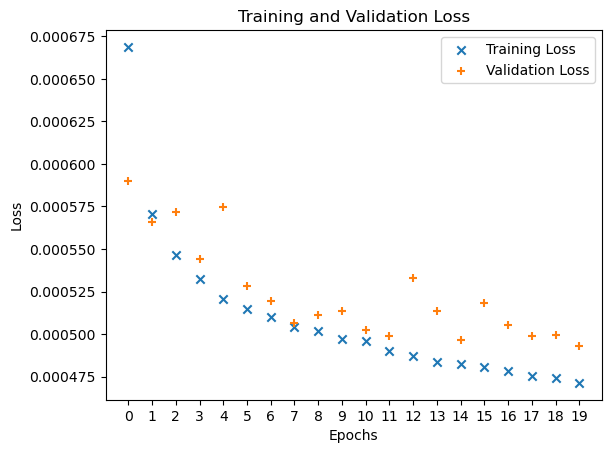

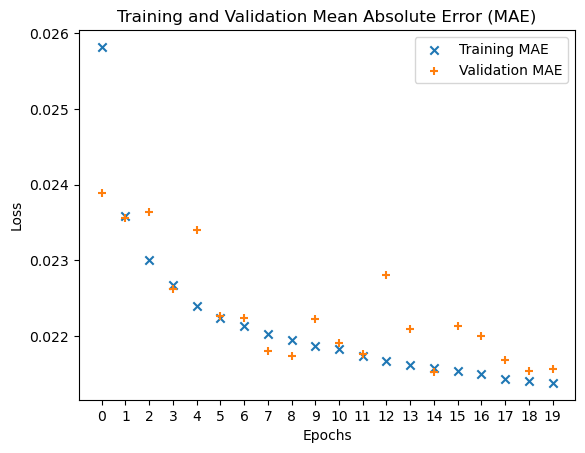

In [7]:
EPOCH_SKIP_PCT = 0
# if history.csv exists, load it
# if os.path.isfile('./history.csv'):
    # history_df = pd.read_csv('./history.csv')

plt.scatter(history_df.index, history_df['loss'], label='Training Loss', marker='x')
plt.scatter(history_df.index, history_df['val_loss'], label='Validation Loss', marker='+')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, epochs, 1))
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

if SAVE_FIGURES: plt.savefig('./graphs/training_loss.png')

plt.figure()
plt.scatter(history_df.index, history_df['mean_absolute_error'], label='Training MAE', marker='x')
plt.scatter(history_df.index, history_df['val_mean_absolute_error'], label='Validation MAE', marker='+')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, epochs, 1))
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Mean Absolute Error (MAE)')
if SAVE_FIGURES: plt.savefig('./graphs/training_mae.png')

plt.show()

In [8]:
# spectra_to_predict = spectra_val
# redshifts_true = redshift_val
# spectra_to_predict = spectra
# redshifts_true = redshifts
spectra_to_predict = spectra_test
redshifts_true = redshift_test

redshift_predicted = model.predict(spectra_to_predict, batch_size=1000)
redshift_predicted = np.reshape(redshift_predicted, (spectra_to_predict.shape[0],))

53/53 [==============================] - 3s 53ms/step


In [33]:
mae = np.mean(np.abs(redshifts_true - redshift_predicted))
print('MAE:', mae)

MAE: 0.021270766114746074


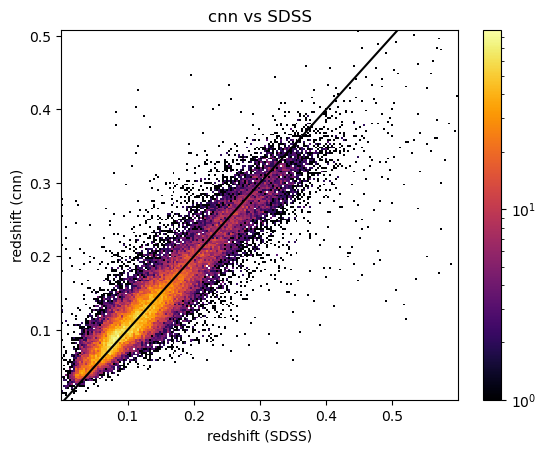

In [9]:
BINS = 200
CMAP = 'inferno'

plt.figure()
plt.hist2d(redshifts_true, redshift_predicted, bins=BINS, norm=matplotlib.colors.LogNorm(), cmap=CMAP)
plt.plot([0, 0.6], [0, 0.6], '-', c='black')
plt.xlabel('redshift (SDSS)')
plt.ylabel('redshift (cnn)')
plt.colorbar()
plt.title("cnn vs SDSS")
if SAVE_FIGURES: plt.savefig('./graphs/cnn_vs_sdss_hist2d.png')

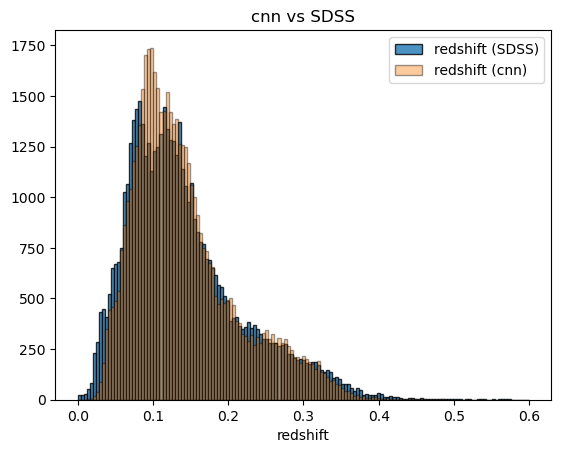

In [10]:
HIST_BIN_SCALE = 150

plt.figure()
plt.hist(redshifts_true, bins=np.linspace(min(redshifts_true), max(redshifts_true), HIST_BIN_SCALE), edgecolor='black', alpha=0.8, label='redshift (SDSS)')
plt.hist(redshift_predicted, bins=np.linspace(min(redshifts_true), max(redshifts_true), HIST_BIN_SCALE), edgecolor='black', alpha=0.4, label='redshift (cnn)')
plt.xlabel('redshift')
plt.title("cnn vs SDSS")
plt.legend()
if SAVE_FIGURES: plt.savefig('./graphs/cnn_vs_sdss_hist.png')

In [28]:
BIN_SIZE = 0.05

absolute_error = redshift_predicted - redshifts_true
bins = np.arange(0, max(redshifts_true) + BIN_SIZE, BIN_SIZE)
bin_indices = np.digitize(redshifts_true, bins)
mean_errors = [np.mean(absolute_error[bin_indices == i]) for i in range(1, len(bins))]
std_errors = [np.std(absolute_error[bin_indices == i]) for i in range(1, len(bins))]

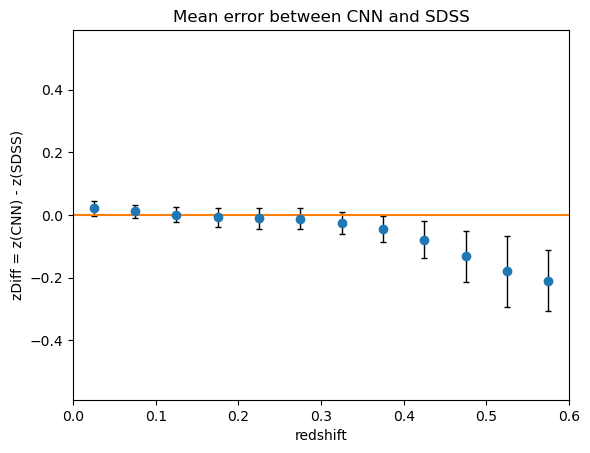

In [36]:
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure()
plt.errorbar(bin_centers, mean_errors, yerr=std_errors, fmt='o', ecolor='black', capsize=2, elinewidth=1, markeredgewidth=1, label='Mean error')
plt.plot([0, 0.6], [0, 0])
plt.xlabel('redshift')
plt.ylabel('zDiff = z(CNN) - z(SDSS)')
plt.ylim([-0.59, 0.59])
plt.xlim([0, 0.6])
plt.title(f"Mean error between CNN and SDSS")
if SAVE_FIGURES: plt.savefig('./graphs/cnn_vs_sdss_mae_errorbar.png')

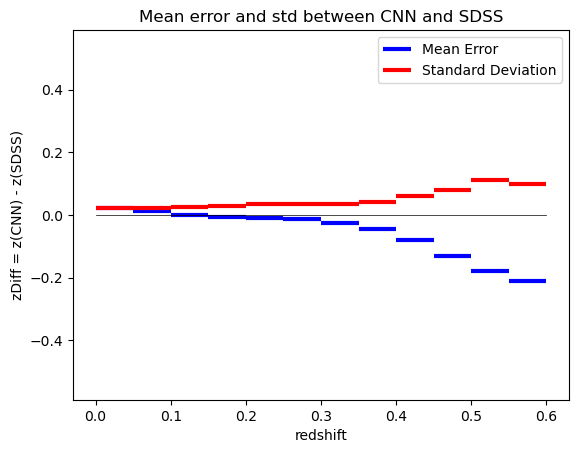

In [30]:
plt.figure()
plt.hlines(mean_errors, bins[:-1], bins[1:], colors=['blue'], linewidth=3.0, label='Mean Error')
plt.hlines(std_errors, bins[:-1], bins[1:], colors=['red'], linewidth=3.0, label='Standard Deviation')
plt.plot([0, 0.6], [0, 0], c='black', linewidth=0.5)
plt.xlabel('redshift')
plt.ylabel('zDiff = z(CNN) - z(SDSS)')
plt.ylim([-0.59, 0.59])
plt.title(f"Mean error and std between CNN and SDSS")
plt.legend()
if SAVE_FIGURES: plt.savefig('./graphs/cnn_vs_sdss_mae.png')

In [35]:
print("| redshift bin | mean error | std error |")
print("|--------------|------------| --------- |")
for i in range(len(mean_errors)):
    print(f"| {bins[i]:.2f} - {bins[i+1]:.2f} | {mean_errors[i]:.4f} | {std_errors[i]:.4f} |")

| redshift bin | mean error | std error |
|--------------|------------| --------- |
| 0.00 - 0.05 | 0.0216 | 0.0236 |
| 0.05 - 0.10 | 0.0117 | 0.0208 |
| 0.10 - 0.15 | 0.0013 | 0.0243 |
| 0.15 - 0.20 | -0.0081 | 0.0296 |
| 0.20 - 0.25 | -0.0110 | 0.0346 |
| 0.25 - 0.30 | -0.0122 | 0.0333 |
| 0.30 - 0.35 | -0.0248 | 0.0351 |
| 0.35 - 0.40 | -0.0458 | 0.0416 |
| 0.40 - 0.45 | -0.0793 | 0.0593 |
| 0.45 - 0.50 | -0.1327 | 0.0806 |
| 0.50 - 0.55 | -0.1804 | 0.1128 |
| 0.55 - 0.60 | -0.2100 | 0.0978 |
